In [5]:
%load_ext autoreload
%autoreload 2

import sys, tqdm
import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))


from caiman.utils.utils import load_dict_from_hdf5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from placefield_detection.utils import (
    prepare_behavior_from_file,
    # get_spiking_data,
    prepare_activity,
    # estimate_stats_from_one_sided_process,
    # obtain_significant_events_from_one_sided_process,
)
import concurrent.futures

pathMouse = Path("../../../../data/845ad")
nbin = 40
f = 15.0


def process_session(args):
    s, pathSession = args
    try:
        pathBehavior = pathSession / "aligned_behavior.pkl"
        behavior = prepare_behavior_from_file(
            pathBehavior,
            nbin=nbin,
            f=f,
        )

        pathActivity = [
            file
            for file in pathSession.iterdir()
            if (
                file.stem.startswith("results_CaImAn")
                and not "compare" in file.stem
                and "redetected" in file.stem
            )
        ][0]

        ld = load_dict_from_hdf5(pathActivity)
        neuron_activity = ld["S"][:, behavior["active"]]
        frate_row = np.zeros(neuron_activity.shape[0])
        for neuron in range(neuron_activity.shape[0]):
            activity = prepare_activity(
                ld["S"][neuron, :], behavior, f=f, only_active=True
            )
            frate_row[neuron] = np.mean(activity["firing_rate"])
            # _, frate_row[neuron], _ = get_spiking_data(neuron_activity[neuron, :])
        return s, frate_row
    except Exception:
        return s, None


sessions = list(enumerate(sorted(pathMouse.glob("Session*"))))
frate = np.empty((len(sessions), 0))
frate[:] = np.nan

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(
        tqdm.tqdm(executor.map(process_session, sessions), total=len(sessions))
    )

for s, frate_row in results:
    if frate_row is not None:
        if len(frate_row) > frate.shape[1]:
            # Extend frate to fit the new data
            extra_cols = len(frate_row) - frate.shape[1]
            frate = np.pad(
                frate,
                ((0, 0), (0, extra_cols)),
                mode="constant",
                constant_values=np.nan,
            )
        frate[s, : len(frate_row)] = frate_row

100%|██████████| 60/60 [00:14<00:00,  4.24it/s]


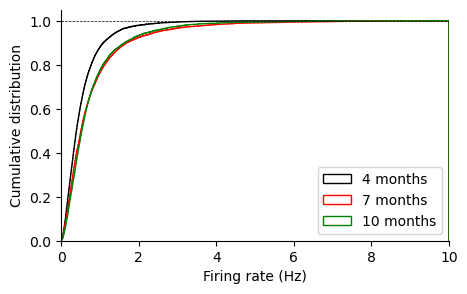

In [7]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.set_xlabel("Firing rate (Hz)")
ax.set_ylabel("Cumulative distribution")

color = ["k", "r", "g"]
ranges = [0, 20, 40, 60]
labels = ["4 months", "7 months", "10 months"]

for set in range(3):
    ax.hist(
        frate[ranges[set] : ranges[set + 1], :].flatten(),
        bins=np.linspace(0, 10, 1000),
        color=color[set],
        cumulative=True,
        density=True,
        histtype="step",
        label=labels[set],
    )

ax.set_xlim(0, 10)
ax.legend()
ax.axhline(1.0, color="k", linestyle="--", linewidth=0.5)
ax.spines[["top", "right"]].set_visible(False)